In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import sys
import os
from datetime import date, timedelta
from numpy import array, random
from matplotlib import use
from matplotlib.pyplot import subplots, rcParams, close
from pandas import datetime, read_csv
from victoriaepi.ama import ama2

/var/folders/mm/5phk2zdj4pv62hj7h7vwtzrc0000gn/T/ipykernel_25669/2515427134.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime, read_csv


In [5]:
"""Configuration parameters."""

# Exit probabilities,   f,    g,       h,   i = exit_probs
exit_probs = [         0.5, 0.04375, 0.25, 0.5]  # Original

out_f=exit_probs[0]

Pobs_I=0.85
Pobs_D=0.95


# 'U^1':[1/5 era 1/7 ... 'H^2':[1/6 era 1/8
R_rates_V2=\
        { 'E'  :[1/5      , r'\sigma_1',  4],\
          'I^S':[1/4      , r'\sigma_2',  3],\
          'H^1':[1/1      , r'\sigma_3',  1],\
          'U^1':[1/5      , r'\sigma_4',  3],\
          'U^2':[1/1      , r'\sigma_5',  1],\
          'I^A':[1/7      , r'\gamma_1',  3],\
          'I^B':[1/7      , r'\gamma_2',  3],\
          'H^2':[1/6      , r'\gamma_3',  3],\
          'H^3':[1/3.3    , r'\gamma_4',  1]}


In [7]:
def AnalyzeZM( clave, T, trim=0, pred=100, init=date(2020, 4, 1), plot_fit=True, workdir="./../", burnin=500):

    # Transfer and standardization of reference date for graphing
    init=init
    ZMs[clave][3] += timedelta(days=4)
    if ZMs[clave][3] <= init:
        # Including the 4-day shift (symptoms onset)
        init_index=(init - ZMs[clave][3]).days
    else: # Including the 4-day shift (symptoms onset)
        init=ZMs[clave][3]
        init_index=0

    if trim == 0:
        out_fnam=clave
    else:
        out_fnam=clave+"_trim%d" % (trim,)
    data_fnam=clave+'.csv'

    intervention_day = [(d-ZMs[clave][3]).days for d in ZMs[clave][4:-(int(ZMs[clave][1])+1)]]

    exit_probs_copy = exit_probs.copy()
    if int(ZMs[clave][1]) > 0:
        relax_day = [(d - ZMs[clave][3]).days for d in ZMs[clave][(-(int(ZMs[clave][1])+1)):-1]]
        exit_probs_copy[0] = out_f#0.4 #=f
        print("ama-2")
    else:
        relax_day = []

    N = ZMs[clave][2]

    zm = ama2( Region=ZMs[clave][0], data_fnam=data_fnam,\
        N=N, out_fnam=out_fnam, init_index=init_index, init=init,\
        intervention_day=intervention_day, relax_day=relax_day, trim=trim, Pobs_I=Pobs_I, Pobs_D=Pobs_D,\
        exit_probs=exit_probs_copy, R_rates=R_rates_V2, workdir=workdir)

    if T > 0:
        #random.seed(1)
        zm.RunMCMC(T=T, pred=pred, plot_fit=plot_fit, burnin=burnin)
    return zm




dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d') #To read the IRAG csv's


# Series of customized plots using PlotEvolution, PlotStateVar and PlotOmega
def PlotFigsZMs( zm, pred=99, q=[10,25,50,75,90], blue=True, workdir='./../'):

    close('all')

    try:
        zm_vmx_Hosp_RI = read_csv(workdir + "data/hosp/%s_DinHospitales.csv" % (zm.clave,), parse_dates=['fecha'], date_parser=dateparse)
        hosp = True
    except:
        hosp = False

    out_fnam=zm.out_fnam

    fig, ax = subplots(figsize=(8,6))
    zm.PlotEvolution( pred=4, cumm=False, log=False, ty=0, ax=ax,\
            label='Median', q=q, blue=blue, right_axis=False,\
            csv_fnam=workdir + "csv/%s_I_short.csv" % (out_fnam,))
    ax.set_title('%s' % (zm.Region,))
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Confirmed cases")
    fig.tight_layout()
    fig.savefig("%s%s_I_short.png" % (workdir + 'figs/',out_fnam))

    fig, ax = subplots(figsize=(8,6))
    zm.PlotEvolution( pred=int(pred/2), cumm=False, log=False, ty=1, ax=ax,\
            label='Median', q=q, blue=blue, right_axis=False,\
            csv_fnam=workdir + "csv/%s_D_short.csv" % (out_fnam,))
    ax.set_title('%s' % (zm.Region,))
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Deaths")
    fig.tight_layout()
    fig.savefig("%s%s_D_short.png" % (workdir + 'figs/',out_fnam))

    fig, ax = subplots(figsize=(8,6))
    zm.PlotEvolution( pred=pred, cumm=False, log=False, ty=0, ax=ax, q=q, blue=blue, right_axis=False,\
        label=r'Median', csv_fnam=workdir + "csv/%s_I_long.csv" % (out_fnam,))
    ax.set_title('%s' % (zm.Region,))
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Confirmed cases")
    fig.tight_layout()
    fig.savefig("%s%s_I_short.png" % (workdir + 'figs/',out_fnam))

    fig, ax = subplots(figsize=(8,6))
    zm.PlotEvolution( pred=int(pred/2), cumm=True, log=False, ty=1, ax=ax, q=q, blue=blue,\
        label=r'Median', right_axis=False, csv_fnam=workdir+"csv/%s_D_long.csv" % (out_fnam,))
    ax.set_title('%s' % (zm.Region,))
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Accumulated deaths")
    fig.tight_layout()
    fig.savefig("%s%s_D_long.png" % (workdir + 'figs/',out_fnam))

    fig, ax = subplots(figsize=(8,6))
    zm.PlotStateVar( 'H^1 H^2 H^3', pred=pred, ax=ax, q=q, blue=blue,\
        label=r'Median', color='red', right_axis=False,\
        csv_fnam=workdir + "csv/%s_Hs.csv" % (out_fnam,))
    if hosp:
        ax.bar(  array(zm_vmx_Hosp_RI['fecha']), array(zm_vmx_Hosp_RI['camasOcupadasHG']), color='red', width=0.5, alpha=0.5)
        ax.plot( zm_vmx_Hosp_RI['fecha'], zm_vmx_Hosp_RI['camasOcupadasHG'], 'ro', markersize=2)
    ax.set_title('%s' % (zm.Region,))
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Occupancy no ICU beds")
    fig.tight_layout()
    fig.savefig("%s%s_Hs.png" % (workdir + 'figs/',out_fnam))

    fig, ax = subplots(figsize=(8,6))
    zm.PlotStateVar( 'U^1', pred=pred, ax=ax, q=q, blue=blue,\
        label=r'Median', color='red',right_axis=False,\
        csv_fnam=workdir + "csv/%s_U1.csv" % (out_fnam,))
    if hosp:
        ax.bar( array(zm_vmx_Hosp_RI['fecha']), array(zm_vmx_Hosp_RI['camasOcupadasUCI_NoUCIVent']), color='red', width=0.5, alpha=0.5)
        ax.plot( zm_vmx_Hosp_RI['fecha'], zm_vmx_Hosp_RI['camasOcupadasUCI_NoUCIVent'], 'ro', markersize=1)
    ax.set_title('%s' % (zm.Region,))
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Occupancy ICU beds")
    fig.tight_layout()
    fig.savefig("%s%s_U1.png" % (workdir + 'figs/',out_fnam))

    # Optional, recovered (see paper):
    fig, ax = subplots( num=7, figsize=(8,6))
    zm.PlotStateVar( 'R', pred=pred, ax=ax, q=q, blue=blue,\
        label=r'Mediana', color='black', right_axis=False)
    ax.set_title('')
    ax.set_xlabel("Date (day.month)")
    ax.set_ylabel("Accumulated cases")
    ax.legend().set_visible(False)
    fig.tight_layout()
    fig.savefig("%s%s_R.png" % (workdir + 'figs/',out_fnam))

    if zm.relax_day != []:
        fig, ax = subplots( num=8, figsize=(8,6))
        zm.PlotOmega(ax=ax)
        ax.set_title('')
        ax.set_ylabel("Density")
        fig.tight_layout()
        fig.savefig("%s%s_Omega.png" % (workdir + 'figs/',out_fnam))

        fig, ax = subplots( num=9, figsize=(8,6))
        zm.PlotOmega( ax=ax, sel=(0,1), mul_f=True)
        ax.set_title('')
        ax.set_ylabel("Density")
        fig.tight_layout()
        fig.savefig("%s%s_Omega_f.png" % (workdir + 'figs/',out_fnam))

    return fig, ax


In [8]:
#ZMs = {  "9-01": ["Mexico city", 2, 21.942666e6, date(2020, 2, 27),  date(2020, 3, 22), date(2020, 4,  3), date(2020, 5, 10), date(2020, 6, 3), None]}
#rcParams.update({'font.size': 14})

['Mexico city', 2, 120000000.0, datetime.date(2020, 2, 27), datetime.date(2020, 3, 22), datetime.date(2020, 4, 3), datetime.date(2020, 5, 10), datetime.date(2020, 6, 3), None]

9-01 T= 25000  burnin= 1000

9-01, Mexico city, T=25000, trim=0
ama-2
File with mcmc samples exists, loading samples ... effective sample size: 26
pytwalk: Running the twalk with 25000 iterations .  Thu, 23 Sep 2021, 22:57:03.
       Finish by Thu, 23 Sep 2021, 23:39.


/usr/local/lib/python3.9/site-packages/victoriaepi/pytwalk.py:393: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))
/usr/local/lib/python3.9/site-packages/victoriaepi/pytwalk.py:368: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)
/usr/local/lib/python3.9/site-packages/victoriaepi/pytwalk.py:410: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) +  (self.nphi-2)*log(beta))
/usr/local/lib/python3.9/site-packages/victoriaepi/pytwalk.py:443: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) + (W1 - W2))


pytwalk:       3072 iterations so far. Finish in approx. 5 min and 3 sec.


/usr/local/lib/python3.9/site-packages/victoriaepi/pytwalk.py:430: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) + (W1 - W2))


pytwalk:       8192 iterations so far. Finish in approx. 3 min and 37 sec.
pytwalk:      21504 iterations so far. Finish in approx. 37 sec.
pytwalk: finished, Thu, 23 Sep 2021, 23:01:34.
AutoMaxlag: maxlag= 551.
IAT: Warning: Not enough lag to calculate IAT

Effective sample size: 76
Sampling 77 model solutions.

Saving files in  ./output/9-01_*.pkl


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$f \\ \\omega$', ylabel='Density'>)

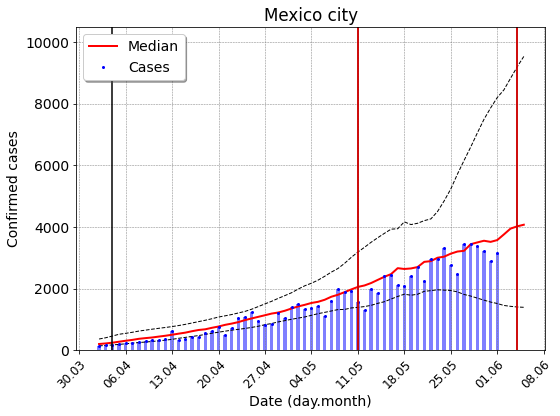

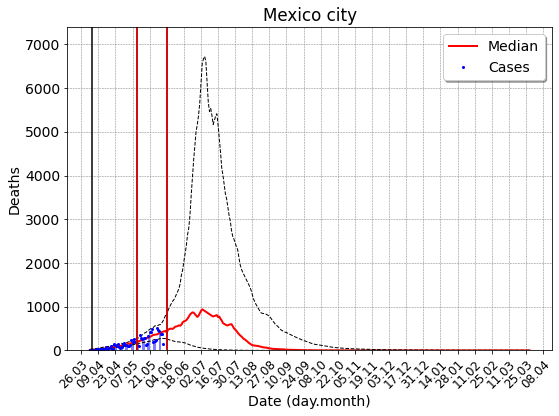

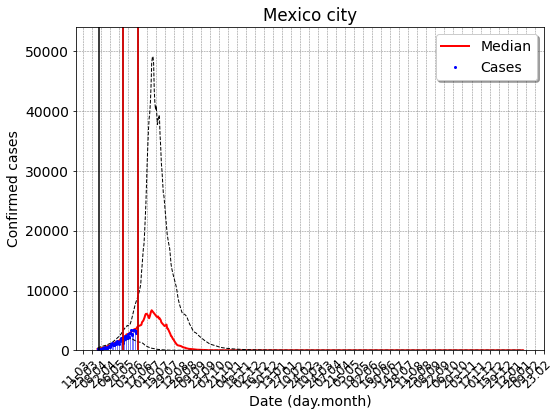

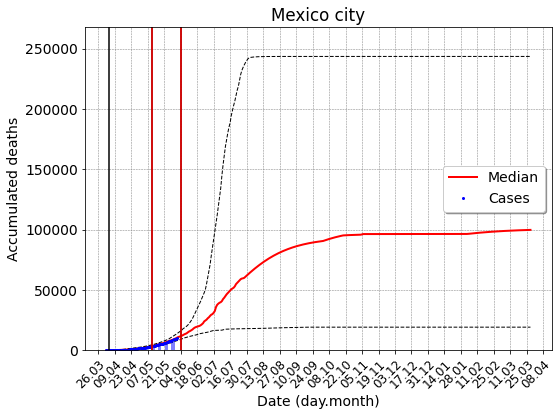

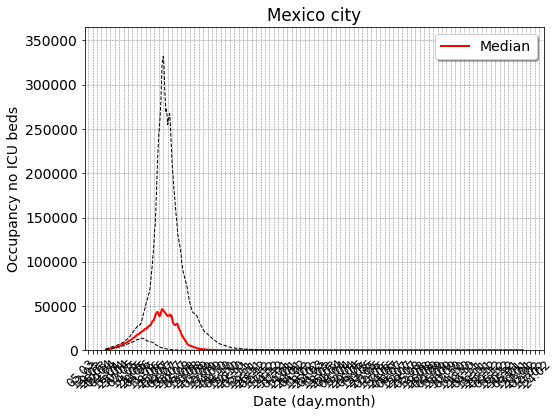

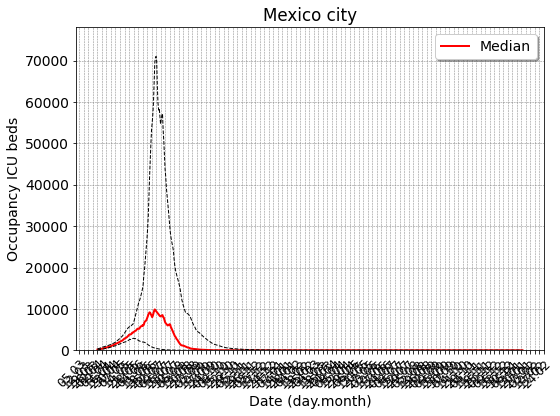

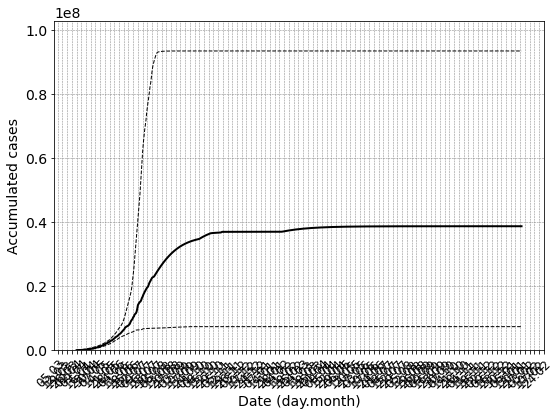

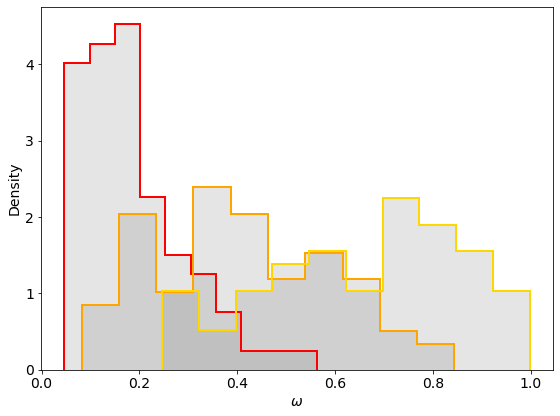

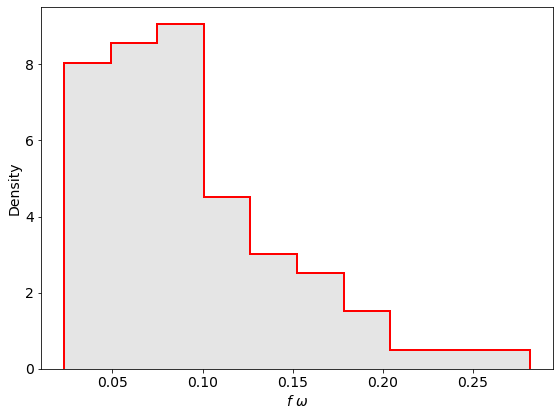

In [143]:
#ZMs = {  "9-01": ["Mexico city", 2, 21.942666e6, date(2020, 2, 27),  date(2020, 3, 22), date(2020, 4,  3), date(2020, 5, 10), date(2020, 6, 3), None]}
ZMs = {  "9-01": ["Mexico city", 2, 120e6, date(2020, 2, 27),  date(2020, 3, 22), date(2020, 4,  3), date(2020, 5, 10), date(2020, 6, 3), None]}

rcParams.update({'font.size': 14})

#     zm = ama2( Region=ZMs[clave][0], data_fnam=data_fnam,\
#         N=N, out_fnam=out_fnam, init_index=init_index, init=init,\
#         intervention_day=intervention_day, relax_day=relax_day, trim=trim, Pobs_I=Pobs_I, Pobs_D=Pobs_D,\
#         exit_probs=exit_probs_copy, R_rates=R_rates_V2, workdir=workdir)

q=[10,25,50,75,90] # Define the quantiles for plotting

workdir = "./" # sys.argv[1]
os.makedirs(workdir, exist_ok=True)
os.makedirs(workdir+"output", exist_ok=True)
os.makedirs(workdir+"figs", exist_ok=True)
os.makedirs(workdir+"data", exist_ok=True)
os.makedirs(workdir+"data/hosp", exist_ok=True)
os.makedirs(workdir+"csv", exist_ok=True)
# os.makedirs(workdir+"logs", exist_ok=True)
# os.makedirs(workdir+"latex", exist_ok=True)
# os.makedirs(workdir+"latex/images", exist_ok=True)

T=25000 #use 10000
burnin=1000 #use 1000

clave = "9-01"  # sys.argv[4]

print(ZMs[clave], flush=True)
print( "\n" + clave + " T=", T, " burnin=", burnin, flush=True)

trim=0
init=date(2020, 4, 1)
#init=date(2020, 4, 13)
pred=600
print( "\n%s, %s, T=%d, trim=%d" % ( clave, ZMs[clave][0], T, trim))
ZMs[clave][-1] = AnalyzeZM( clave, T=T, trim=trim, init=init, pred=800, plot_fit=False, burnin=burnin, workdir=workdir)
ZMs[clave][-1].clave = clave
zm = ZMs[clave][-1]
# Custom plots for a metro zone
PlotFigsZMs(ZMs[clave][-1], pred=pred, blue=False, workdir=workdir)